<a href="https://colab.research.google.com/github/Himanshu41/HealthConditionPredictionusingEEGdata/blob/main/Health_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import statements
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Assigning path of datasets
#Please change the path according to your file paths
raw_data_path = "/content/drive/My Drive/Colab Notebooks/Data Sources/Raw Data/EEG dataset.csv"
psychiatric_data_path = "/content/drive/My Drive/Colab Notebooks/Data Sources/Psychiatric Disorders/EEG.machinelearing_data_BRMH.csv"
siezures_data_path = "/content/drive/My Drive/Colab Notebooks/Data Sources/Epileptic Seizure Recognition.csv"

In [4]:
#DataPreprocessing
def preProcessDataForModel(data, label = []):
  scaler = MinMaxScaler()
  if isinstance(data, pd.DataFrame):                                            #Checking if the the dataset is pandas Data Frame or not. If not, then convert it to Pandas Dataframe
    data = pd.DataFrame(data)
  cleanedData = data.fillna(data.mean(), inplace=True)
  normalizedData = scaler.fit_transform(data)
  normalized_df = pd.DataFrame(normalizedData, columns=data.columns)
  if len(label) == 0:
    X_train, X_test = train_test_split(data, test_size=0.4)
    return X_train, X_test
  else:
    X_train, X_test, y_train, y_test = train_test_split(data, label)
    return X_train, X_test, y_train, y_test

In [5]:
#Model
class HealthPrediction:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.kmeans = KMeans(n_clusters = num_clusters)
        self.svm = SVC(C=1.0, kernel='rbf')
        self.clusterLabels = dict()
        self.kmeansAccuracy = 0
        self.svmAccuracy = 0
        self.kmeansF1Score = 0
        self.svmF1Score = 0
        self.kmeansPrecision = 0
        self.svmPrecision = 0
        self.kmeansRecall = 0
        self.svmRecall = 0

    def trainKmeans(self, X):
      self.X = X
      self.kmeans.fit(X)
      return self

    def trainSVM(self, X, y):
      self.svm.fit(X,y)
      return self

    def fit(self, unlabelledData, labelledData, labels, allLabels):
      self.trainKmeans(unlabelledData)
      no_of_features = self.kmeans.n_features_in_
      selectedData1 = self.selectFeature(no_of_features = no_of_features, X = labelledData[0])
      selectedData2 = self.selectFeature(no_of_features = no_of_features, X = labelledData[1])
      combined_data = pd.DataFrame(np.vstack((selectedData1, selectedData2)))
      combined_labels = np.hstack((labels[0], labels[1]))
      self.trainSVM(combined_data, combined_labels)
      for _, row in combined_data.iterrows():
          self.addLablesToClusters(row.values)
      X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size = 0.4)
      self.evaluateAlgorithms(X_test, y_test)
      return self

    def addLablesToClusters(self, labelledData):
      clusterAssignment = self.kmeans.predict([labelledData])[0]
      labelAssignment = self.svm.predict([labelledData])[0]
      if clusterAssignment not in self.clusterLabels:
          self.clusterLabels[clusterAssignment] = labelAssignment
      return self

    def predict(self, X):
      X = self.selectFeature(no_of_features = self.kmeans.n_features_in_, X=X)
      kmeansPredictions = self.kmeans.predict(X)
      conditions = [self.clusterLabels[i] for i in kmeansPredictions]
      return conditions

    def selectFeature(self, no_of_features, X):
      X_selected = X.iloc[:, :no_of_features]
      return X_selected

    def evaluateAlgorithms(self, X,Y):
      kmeansPrediction = self.kmeans.predict(X)
      SVMPrediction = self.svm.predict(X)
      self.kmeansAccuracy = accuracy_score(Y, kmeansPrediction)
      self.svmAccuracy = accuracy_score(Y, SVMPrediction)
      self.kmeansF1Score = f1_score(Y, kmeansPrediction, average='weighted')
      self.svmF1Score = f1_score(Y, SVMPrediction, average='weighted')
      self.kmeansPrecision = precision_score(Y, kmeansPrediction, average='weighted')
      self.svmPrecision = precision_score(Y, SVMPrediction, average='weighted')
      self.kmeansRecall = recall_score(Y, kmeansPrediction, average='weighted')
      self.svmRecall = recall_score(Y, SVMPrediction, average='weighted')
      return self

    def printEvaluationOfAlgorithms(self):
      print("---------------Kmeans---------------")
      print("Accuracy: " + str(self.kmeansAccuracy))
      print("Precision: " + str(self.kmeansPrecision))
      print("Recall: " + str(self.kmeansRecall))
      print("F1 Score: " + str(self.kmeansF1Score))
      print("-----------------SVM-----------------")
      print("Accuracy: " + str(self.svmAccuracy))
      print("Precision: " + str(self.svmPrecision))
      print("Recall: " + str(self.svmRecall))
      print("F1 Score: " + str(self.svmF1Score))
      return self

    def plotClusters(self):
      pca = PCA(n_components=2)
      reduced_data = pca.fit_transform(self.X)
      cluster_labels = self.kmeans.labels_
      plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis')
      plt.scatter(self.kmeans.cluster_centers_[:, 0], self.kmeans.cluster_centers_[:, 1], c='#000000')
      plt.title('Clusters')
      plt.colorbar()
      plt.show()
      return self


In [6]:
#Reading Data and dropping the columns that are not in use for better training
raw_data = pd.read_csv(raw_data_path)
psychiatric_data = pd.read_csv(psychiatric_data_path)
siezure_data = pd.read_csv(siezures_data_path)
raw_data_train = raw_data.drop(columns=['Id','Class'])
psychiatric_data_train = psychiatric_data.drop(columns=['IQ', 'no.','sex','age','eeg.date','education','main.disorder','specific.disorder'])
siezure_data_train = siezure_data.drop(columns=['Unnamed','y'])

In [7]:
#Checking the data
print(raw_data_train.head())
print('----------------------------------------------------------------------------------------------------')
print(psychiatric_data_train.head())
print('----------------------------------------------------------------------------------------------------')
print(siezure_data_train.head())

         F1        F2        F3        F4        F5        F6        F7  \
0  1.000000  0.760188  0.760727  1.000000  1.000000  0.619948  0.760190   
1  0.760193  0.760200  1.000000  0.760203  0.760206  0.760194  0.760198   
2  0.760190  1.000000  1.000000  0.760193  1.000000  1.000000  1.000000   
3  0.760194  0.760202  1.000000  0.760188  0.760199  0.760200  0.760201   
4  1.000000  0.760193  0.619927  1.000000  1.000000  1.000000  0.760205   

         F8        F9       F10  ...       F76       F77      F78       F79  \
0  0.619946  0.760204  0.620021  ...  1.000000  0.760201  0.76030  1.000000   
1  1.000000  0.760197  1.000000  ...  0.760189  0.760219  0.76031  0.760312   
2  1.000000  1.000000  0.760192  ...  1.000000  1.000000  1.00000  0.760275   
3  0.620025  0.760199  0.760198  ...  0.760424  0.760261  1.00000  0.760253   
4  0.619962  1.000000  0.760207  ...  0.765161  1.000000  1.00000  0.760188   

        F80      F81      F82      F83      F84      F85  
0  0.620375   5

In [8]:
set(psychiatric_data['specific.disorder'])

{'Acute stress disorder',
 'Adjustment disorder',
 'Alcohol use disorder',
 'Behavioral addiction disorder',
 'Bipolar disorder',
 'Depressive disorder',
 'Healthy control',
 'Obsessive compulsitve disorder',
 'Panic disorder',
 'Posttraumatic stress disorder',
 'Schizophrenia',
 'Social anxiety disorder'}

In [9]:
#Encoding All the disorders to 0, Panic Disorder to 1, Schizophrenia to 2 for training and Healthy Control to 3
psychiatric_data['encoded_disorder'] = 0
psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Panic disorder', 'encoded_disorder'] = 1
psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Schizophrenia', 'encoded_disorder'] = 2
psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Healthy control', 'encoded_disorder'] = 3
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Behavioral addiction disorder', 'encoded_disorder'] = 5
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Posttraumatic stress disorder', 'encoded_disorder'] = 6
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Acute stress disorder', 'encoded_disorder'] = 7
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Adjustment disorder', 'encoded_disorder'] = 8
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Alcohol use disorder', 'encoded_disorder'] = 9
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Bipolar disorder', 'encoded_disorder'] = 10
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Depressive disorder', 'encoded_disorder'] = 11
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Obsessive compulsitve disorder', 'encoded_disorder'] = 12
#psychiatric_data.loc[psychiatric_data['specific.disorder'] == 'Social anxiety disorder', 'encoded_disorder'] = 13
psychiatric_data

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,encoded_disorder
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,0
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,0
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,0
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,0
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230,3
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868,3
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111,3
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446,3


In [10]:
#Encoding Siezure data labels for training
siezure_data['encoded_disorder'] = 0
siezure_data.loc[siezure_data['y']==1, 'encoded_disorder'] = 4
siezure_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X171,X172,X173,X174,X175,X176,X177,X178,y,encoded_disorder
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-15,-31,-77,-103,-127,-116,-83,-51,4,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,150,146,152,157,156,154,143,129,1,4
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,64,48,19,-12,-30,-35,-35,-36,5,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-81,-80,-77,-85,-77,-72,-69,-65,5,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,2,-12,-32,-41,-65,-83,-89,-73,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,16,12,5,-1,-18,-37,-47,-48,2,0
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-33,-7,14,27,48,77,117,170,1,4
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-48,-61,-62,-67,-30,-2,-1,-8,5,0
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,135,148,143,116,86,68,59,55,3,0


In [11]:
#Preprocess the Data
raw_X_train, raw_X_test = preProcessDataForModel(raw_data_train)
psychiatric_X_train, psychiatric_X_test, psychiatric_y_train, psychiatric_y_test = preProcessDataForModel(psychiatric_data_train, psychiatric_data['encoded_disorder'])
siezure_X_train, siezure_X_test, siezure_y_train, siezure_y_test = preProcessDataForModel(siezure_data_train, siezure_data['encoded_disorder'])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [12]:
#Model initialization
myModel = HealthPrediction(num_clusters = 5)

In [13]:
#model Training
myModel.fit(unlabelledData = raw_X_train, labelledData = [psychiatric_X_train, siezure_X_train], labels = [psychiatric_y_train, siezure_y_train], allLabels=[0,1,2,3,4])
#myModel.fit(unlabelledData = raw_X_train, labelledData = [psychiatric_X_train, siezure_X_train], labels = [psychiatric_y_train, siezure_y_train], allLabels=[0,1,2,3,4,5])
#myModel.fit(unlabelledData = raw_X_train, labelledData = [psychiatric_X_train, siezure_X_train], labels = [psychiatric_y_train, siezure_y_train], allLabels=[0,1,2,3,4,5,6])
#myModel.fit(unlabelledData = raw_X_train, labelledData = [psychiatric_X_train, siezure_X_train], labels = [psychiatric_y_train, siezure_y_train], allLabels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature 

In [14]:
#Combining data from 2 dataset for testing
no_of_features = myModel.kmeans.n_features_in_
selectedData1 = myModel.selectFeature(no_of_features = no_of_features, X = psychiatric_X_test)
selectedData2 = myModel.selectFeature(no_of_features = no_of_features, X = siezure_X_test)
combined_test_data = pd.DataFrame(np.vstack((selectedData1, selectedData2)))
combined_test_labels = np.hstack((psychiatric_y_test, siezure_y_test))

prediction = myModel.predict(combined_test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [15]:
#Calculating Accuracy and F1 Score of the model
acc = accuracy_score(list(combined_test_labels), prediction)
f1Score = f1_score(list(combined_test_labels), prediction, average='weighted')

In [16]:
#Printing Accuracy and F1 Score of the Model
print('Accuracy: ' + str(acc))
print('F1 Score: ' + str(f1Score))

Accuracy: 0.6902313624678663
F1 Score: 0.6962940691794429


In [17]:
#Printing Evaluation of algorithms separately
myModel.printEvaluationOfAlgorithms()

---------------Kmeans---------------
Accuracy: 0.5313336904124264
Precision: 0.6881364675262296
Recall: 0.5313336904124263
F1 Score: 0.5961499479339809
-----------------SVM-----------------
Accuracy: 0.9552758435993572
Precision: 0.9340661388002538
Recall: 0.9552758435993572
F1 Score: 0.9439383943699309


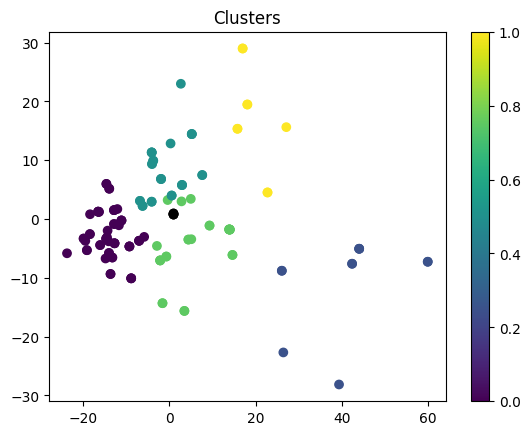

In [18]:
#Generate Scatter Plot
myModel.plotClusters()